**Importing Libraries**

In [60]:
using Pkg
Pkg.add(["Optimisers","CSV","DataFrames","Lux", "Flux", "MLUtils", "Plots","OneHotArrays", "Statistics", "Random", "CUDA", "MLDatasets","Zygote"])

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.11/Project.toml`
  No Changes to `~/.julia/environments/v1.11/Manifest.toml`


In [61]:
using CSV, DataFrames, Flux, Lux, Optimisers, MLUtils, Statistics, Plots, Random, MLDatasets
using Lux, Optimisers, Zygote, MLUtils, MLDatasets, Statistics, Plots
using OneHotArrays: onehotbatch, onecold
using Random
using Flux: softmax,Losses
using Zygote: gradient
using Lux: Chain, FlattenLayer, Dense, relu

**Loading Data**

1. Implement a one hidden layer MLP, and vary the size of the hidden layer (10, 20, 40, 50, 100,
300) and train for 10 Epochs on FashionMNIST and store the final test accuracy. Then plot
the accuracy as a function of the hidden layer size.

In [63]:
# FashionMNIST
train_x, train_y = FashionMNIST(:train)[:]
test_x,  test_y  = FashionMNIST(:test)[:]


train_x = Float32.(reshape(train_x, 28, 28, 1, :)) ./ 255
test_x = Float32.(reshape(test_x, 28, 28, 1, :)) ./ 255
train_y = onehotbatch(train_y, 0:9)
test_y = onehotbatch(test_y, 0:9)

# MLP model
function create_mlp(hidden_size)
    Chain(
        FlattenLayer(),
        Dense(28*28, hidden_size, relu),
        Dense(hidden_size, 10),
    )
end

# Training function
function train_model(model, ps, st, data, testdata; epochs=10, η=0.01)
    opt = Optimisers.Adam(η)
    st_opt = Optimisers.setup(opt, ps)

    for epoch in 1:epochs
        for (x, y) in data
            gs = gradient(ps) do p
                ŷ, _ = Lux.apply(model, x, p, st)
                Losses.logitcrossentropy(ŷ, y)
            end
            st_opt, ps = Optimisers.update(st_opt, ps, gs[1]) # gs is a tuple, gs[1] is gradient wrt ps
        end
    end

    # Evaluate test set
    test_pred = Lux.apply(model, testdata[1], ps, st)[1]
    accuracy = mean(onecold(test_pred) .== onecold(testdata[2]))
    return accuracy
end


hidden_sizes = [10, 20, 40, 50, 100, 300]
accuracies = Float64[]

for h in hidden_sizes
    model = create_mlp(h)
    rng = Random.default_rng() # Initialize rng here
    ps, st = Lux.setup(rng, model)
    acc = train_model(model, ps, st,
                     DataLoader((train_x, train_y), batchsize=32, shuffle=true),
                     (test_x, test_y))
    push!(accuracies, acc)
    println("Hidden Size $h -> Accuracy: $acc")
end

Hidden Size 10 -> Accuracy: 0.8247
Hidden Size 20 -> Accuracy: 0.8387
Hidden Size 40 -> Accuracy: 0.8545
Hidden Size 50 -> Accuracy: 0.8576
Hidden Size 100 -> Accuracy: 0.8664
Hidden Size 300 -> Accuracy: 0.8689


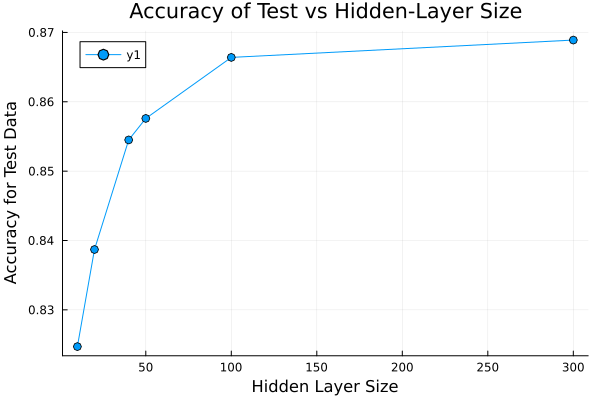

In [64]:
#  Plot results
plot(hidden_sizes, accuracies, xlabel="Hidden Layer Size", ylabel="Accuracy for Test Data",
     title="Accuracy of Test vs Hidden-Layer Size", marker=:o)

2. Use the same network with fixed hidden layer size of 30 to estimate the impact of random initialisation. Run the network 10 times with different weight initialisation. Compute standard
deviation and mean. Visualize the datapoints in a plot to make the fluctuations of the final
test accuracy visible.

In [65]:
no_of_runs = 10
accuracies_30 = Float64[]

for _ in 1:no_of_runs
    rng = Random.default_rng()
    model = create_mlp(30)
    ps, st = Lux.setup(rng, model)
    acc = train_model(model, ps, st,
                     DataLoader((train_x, train_y), batchsize=32, shuffle=true),
                     (test_x, test_y))
    push!(accuracies_30, acc)
end

μ = mean(accuracies_30)
σ = std(accuracies_30)

println("Mean accuracy: $μ")
println("Standard deviation: $σ")

Mean accuracy: 0.8453900000000001
Standard deviation: 0.0055271953908730825


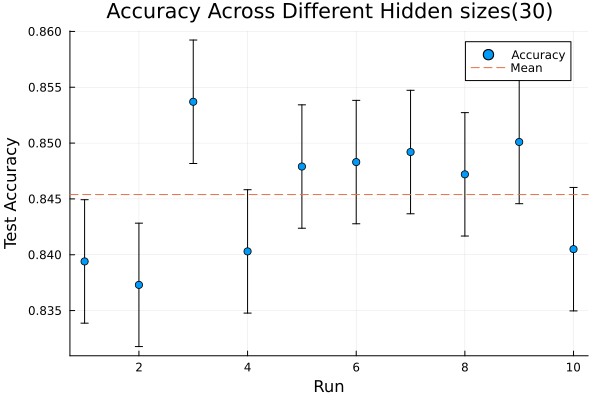

In [66]:
#Plot
scatter(1:no_of_runs, accuracies_30, yerror=σ, xlabel="Run", ylabel="Test Accuracy",
        title="Accuracy Across Different Hidden sizes(30)",
        label="Accuracy")
hline!([μ], label="Mean", linestyle=:dash)

3. Train the model with a batch size of 32 for 25 epochs. Use a decaying learning rate schedule
of your choice.

In [67]:
function train_with_schedule(model, ps, st, data, testdata; epochs=25, batchsize=32)

    # decay learning rate schedule

    schedule(epoch) = 0.01 * exp(-0.1 * epoch)


    function loss(x, y, ps, st)
        y_pred, st = Lux.apply(model, x, ps, st)
        logits = softmax(y_pred)
        return -sum(y .* log.(logits)) / size(y, 2), st  # Cross-entropy loss
    end

    for epoch in 1:epochs
        η = schedule(epoch)
        opt = Optimisers.Adam(η)
        st_opt = Optimisers.setup(opt, ps)

        for (x, y) in DataLoader(data, batchsize=batchsize, shuffle=true)
            (l, st), back = Zygote.pullback(p -> loss(x, y, p, st), ps)
            gs = back((1.0f0, nothing))[1]  # Get gradients only for parameters
            st_opt, ps = Optimisers.update(st_opt, ps, gs)
        end

        if epoch % 5 == 0
            test_pred, _ = Lux.apply(model, testdata[1], ps, st)
            acc = mean(onecold(test_pred) .== onecold(testdata[2]))
            println("Epoch $epoch, Test Accuracy: $acc")
        end
    end

    # Final accuracy
    test_pred, _ = Lux.apply(model, testdata[1], ps, st)
    accuracy = mean(onecold(test_pred) .== onecold(testdata[2]))
    return accuracy
end

# Usage example:
model = create_mlp(100)
rng = Random.default_rng()
ps, st = Lux.setup(rng, model)
acc = train_with_schedule(model, ps, st, (train_x, train_y), (test_x, test_y))
println("Final test accuracy: $acc")


Epoch 5, Test Accuracy: 0.852
Epoch 10, Test Accuracy: 0.8646
Epoch 15, Test Accuracy: 0.8715
Epoch 20, Test Accuracy: 0.8737
Epoch 25, Test Accuracy: 0.873
Final test accuracy: 0.873


4. Optimise the batch size and the learning rate schedule via a small grid search.

In [68]:
batch_sizes = [16, 32, 64, 128]
lr_schedules = [
    (epoch -> 0.1 * exp(-0.1 * epoch), "Exp Decay 0.1"),
    (epoch -> 0.01 * exp(-0.05 * epoch), "Exp Decay 0.01"),
    (epoch -> 0.001 * (1 + cos(π * epoch / 25)), "Cosine"),
]

best_acc = 0.0
best_params = (bs=0, schedule=nothing)

for bs in batch_sizes
    for (schedule, desc) in lr_schedules
        model = create_mlp(100)
        ps, st = Lux.setup(rng, model)

        function custom_train(model, ps, st, data, testdata; epochs=25)
            for epoch in 1:epochs
                η = schedule(epoch)
                opt = Optimisers.Adam(η)
                st_opt = Optimisers.setup(opt, ps)

                function loss(x, y, ps, st)
                    y_pred, st = Lux.apply(model, x, ps, st)
                    logits = softmax(y_pred)
                    return -sum(y .* log.(logits)) / size(y, 2), st
                end

                for (x, y) in DataLoader(data, batchsize=bs, shuffle=true)
                    (l, st), back = Zygote.pullback(p -> loss(x, y, p, st), ps)
                    gs = back((1.0f0, nothing))[1]
                    st_opt, ps = Optimisers.update(st_opt, ps, gs)
                end
            end

            test_pred, _ = Lux.apply(model, testdata[1], ps, st)
            mean(onecold(test_pred) .== onecold(testdata[2]))
        end

        acc = custom_train(model, ps, st, (train_x, train_y), (test_x, test_y))
        println("Batch size = $bs, Schedule = $desc: Accuracy = $acc")

        if acc > best_acc
            best_acc = acc
            best_params = (bs=bs, schedule=desc)
        end
    end
end

println("Best params: Batch size = $(best_params.bs), Schedule = $(best_params.schedule) with accuracy = $best_acc")

Batch size = 16, Schedule = Exp Decay 0.1: Accuracy = 0.1
Batch size = 16, Schedule = Exp Decay 0.01: Accuracy = 0.1
Batch size = 16, Schedule = Cosine: Accuracy = 0.8573
Batch size = 32, Schedule = Exp Decay 0.1: Accuracy = 0.1
Batch size = 32, Schedule = Exp Decay 0.01: Accuracy = 0.8802
Batch size = 32, Schedule = Cosine: Accuracy = 0.8528
Batch size = 64, Schedule = Exp Decay 0.1: Accuracy = 0.1
Batch size = 64, Schedule = Exp Decay 0.01: Accuracy = 0.8721
Batch size = 64, Schedule = Cosine: Accuracy = 0.8403
Batch size = 128, Schedule = Exp Decay 0.1: Accuracy = 0.1
Batch size = 128, Schedule = Exp Decay 0.01: Accuracy = 0.8638
Batch size = 128, Schedule = Cosine: Accuracy = 0.8347
Best params: Batch size = 32, Schedule = Exp Decay 0.01 with accuracy = 0.8802


5. Use the parameters which yield the best and train the network. Did you improve your result
in 3?


In [69]:
function create_optimized_trainer(bs, schedule)
    function trainer(model, ps, st, data, testdata; epochs=25)
        for epoch in 1:epochs
            η = schedule(epoch)
            opt = Optimisers.Adam(η)
            st_opt = Optimisers.setup(opt, ps)

            function loss(x, y, ps, st)
                y_pred, st = Lux.apply(model, x, ps, st)
                logits = softmax(y_pred)
                return -sum(y .* log.(logits)) / size(y, 2), st
            end

            for (x, y) in DataLoader(data, batchsize=bs, shuffle=true)
                (l, st), back = Zygote.pullback(p -> loss(x, y, p, st), ps)
                gs = back((1.0f0, nothing))[1]
                st_opt, ps = Optimisers.update(st_opt, ps, gs)
            end
        end

        test_pred, _ = Lux.apply(model, testdata[1], ps, st)
        mean(onecold(test_pred) .== onecold(testdata[2]))
    end
    return trainer
end

create_optimized_trainer (generic function with 1 method)

In [70]:
best_schedule = epoch -> 0.01 * exp(-0.05 * epoch)
best_bs = 64  # Example best batch size

optimized_train = create_optimized_trainer(best_bs, best_schedule)
model = create_mlp(100)
ps, st = Lux.setup(rng, model)
final_acc = optimized_train(model, ps, st, (train_x, train_y), (test_x, test_y))
println("Final optimized accuracy: $final_acc")

Final optimized accuracy: 0.8711


No, the accuracy went down from 0.873 to 0.871.